In [14]:
from Dataset import *
from Utils import *
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
plt.style.use('ggplot')
sns.set()
% matplotlib inline

Pre-trained GloVe word vectors are used to perform word embedding. Vector of length 25 is picked.

In [3]:
embedding_index, vtr_dim = import_glove(25)

In [4]:
col_fire_12 = dataset('2012_Colorado_wildfires/2012_Colorado_wildfires-tweets_labeled.csv')
col_flood_13 = dataset('2013_Colorado_floods/2013_Colorado_floods-tweets_labeled.csv')
aus_fire_13 = dataset('2013_Australia_bushfire/2013_Australia_bushfire-tweets_labeled.csv')
aus_flood_13 = dataset('2013_Queensland_floods/2013_Queensland_floods-tweets_labeled.csv')
col_fire_12_g = col_fire_12.glove(embedding_index, vtr_dim)
col_flood_13_g = col_flood_13.glove(embedding_index, vtr_dim)
aus_fire_13_g = aus_fire_13.glove(embedding_index, vtr_dim)
aus_flood_13_g = aus_flood_13.glove(embedding_index, vtr_dim)
col_fire_12_lb = to_categorical(col_fire_12.df.label)
col_flood_13_lb = to_categorical(col_flood_13.df.label)
aus_fire_13_lb = to_categorical(aus_fire_13.df.label)
aus_flood_13_lb = to_categorical(aus_flood_13.df.label)

Some useful functions here

In [5]:
def incremental_learning_prob(model, tweets, step=10, threshold=0.75):
    subset_len = tweets.shape[0]/step
    marks = [subset_len*i for i in range(step)]
    marks.append(tweets.shape[0])
    for i in range(step):
        text = tweets[marks[i]: marks[i+1]]
        y_pred = model.predict(x=text)
        x_confident = np.asarray([text[j] for j in range(len(y_pred)) if y_pred[j][0] >= threshold or y_pred[j][1] >= threshold])
        y_confident = [y_pred[j] for j in range(len(y_pred)) if y_pred[j][0] >= threshold or y_pred[j][1] >= threshold]
        label = to_categorical(map(lambda x: 0 if x[0]>=threshold else 1, y_confident))
        weight = np.array([(max(i)-0.5)/0.5 for i in y_confident])
        model.train_on_batch(x_confident, label, sample_weight=weight)#, validation_split=0.3, epochs = 10, callbacks=[EarlyStopping(patience=3)])

In [6]:
def incremental_learning_det(model, tweets, step=10, confidence=0.95):
    subset_len = tweets.shape[0]/step
    marks = [subset_len*i for i in range(step)]
    marks.append(tweets.shape[0])
    for i in range(step):
        text = tweets[marks[i]: marks[i+1]]
        y_pred = model.predict(x=text)
        x_confident = np.asarray([text[j] for j in range(len(y_pred)) if y_pred[j][0] >= confidence or y_pred[j][1] >= confidence])
        y_confident = [y_pred[j] for j in range(len(y_pred)) if y_pred[j][0] >= confidence or y_pred[j][1] >= confidence]
        label = to_categorical(map(lambda x: 0 if x[0]>=confidence else 1, y_confident))
        model.train_on_batch(x_confident, label)#, validation_split=0.3, epochs = 10, callbacks=[EarlyStopping(patience=3)])

In [20]:
def create_cnn_model(conv=[32, 16], window=[3,3], pool=3, dropout=0.3, penalty=0.01, input_shape=25, batch_normalize=False, initial_lr=0.001):
    model = Sequential()
    model.add(Conv1D(conv[0], window[0], activation='relu', kernel_initializer = 'he_normal', 
                   kernel_regularizer=regularizers.l2(penalty), input_shape=(None,input_shape)))
    model.add(MaxPooling1D(pool))
    model.add(Conv1D(conv[1], window[1], activation='relu', kernel_initializer = 'he_normal', 
                   kernel_regularizer=regularizers.l2(penalty)))
    model.add(GlobalMaxPooling1D())
    if batch_normalize:
        model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(2, activation='softmax'))
    optimizer = Adam(lr=initial_lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [8]:
def shuffle_train(model, data, text, path, k=10, n_epoch=10, batch_size=64, earlystop=None):
    min_val_loss = float('inf')
    if isinstance(earlystop, int):
        n_earlystopping = [earlystop]*k
    elif isinstance(earlystop, list) and len(earlystop)==k:
        n_earlystopping = earlystop
    else:
        print 'earlystop is not specified or the input is invalid(has either to be an int or a list with length equal to k), use default setting'
        n_earlystopping = [7]*(k/4)+[6]*(k/4)+[5]*(k/4)+[4]*(k-k/4*3)
    mcp = ModelCheckpoint(filepath=path, monitor='val_loss', save_best_only=True, save_weights_only=True)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=0, mode='auto', cooldown=0, min_lr=0.0001)
    history = {'acc':[], 'loss':[], 'val_acc':[], 'val_loss':[]}
    ##### n_epoch*k epochs in total######
    CLR = K.get_value(model.optimizer.lr)
    for i in range(k):
        K.set_value(model.optimizer.lr, CLR)
        df = data.df.sample(frac=1)
        tweet_g = text[df.index.values]
        his = model.fit(tweet_g, to_categorical(df.label), callbacks=[EarlyStopping(monitor='val_loss', patience=n_earlystopping[i], min_delta=0.001),
            mcp, rlr], validation_split=0.2, batch_size=batch_size, epochs=n_epoch)
        for metric in ['acc', 'loss', 'val_acc', 'val_loss']:
            history[metric].extend(his.history[metric])
        if min(his.history['val_loss']) < min_val_loss:
            min_val_loss = min(his.history['val_loss'])
        if len(his.history['acc']) < n_epoch:
            break
        CLR = K.get_value(model.optimizer.lr)
        model.load_weights(path)
    model.save(path)
    return history

In [27]:
def metric_drawing(title, path=None, Model=None):
    if Model is None:
        model = load_model(path)
    y_p1 = model.predict(col_flood_13_g)
    y_pred1 = []
    y_p2 = model.predict(aus_fire_13_g)
    y_pred2 = []
    y_p3 = model.predict(aus_flood_13_g)
    y_pred3 = []
    precision = []
    recall = []
    f1 = []
    for y in y_p1:
        if y[0]>y[1]:
            y_pred1.append(0)
        else:
            y_pred1.append(1)
    precision.append(metrics.precision_score(col_flood_13.df.label, y_pred1))
    recall.append(metrics.recall_score(col_flood_13.df.label, y_pred1))
    f1.append(metrics.f1_score(col_flood_13.df.label, y_pred1))
    for y in y_p2:
        if y[0]>y[1]:
            y_pred2.append(0)
        else:
            y_pred2.append(1)
    precision.append(metrics.precision_score(aus_fire_13.df.label, y_pred2))
    recall.append(metrics.recall_score(aus_fire_13.df.label, y_pred2))
    f1.append(metrics.f1_score(aus_fire_13.df.label, y_pred2))
    for y in y_p3:
        if y[0]>y[1]:
            y_pred3.append(0)
        else:
            y_pred3.append(1)
    precision.append(metrics.precision_score(aus_flood_13.df.label, y_pred3))
    recall.append(metrics.recall_score(aus_flood_13.df.label, y_pred3))
    f1.append(metrics.f1_score(aus_flood_13.df.label, y_pred3))

    plt.bar([0.9,1.9,2.9], precision, width=0.1, label='precision')
    plt.bar([1,2,3], recall, width=0.1, label='recall')
    plt.bar([1.1,2.1,3.1], f1, width=0.1, label='f1-score')
    plt.xticks([1,2,3], ['col_flood_13', 'aus_fire_13', 'aus_flood_13'])
    plt.ylim([0,1])
    plt.legend(loc='best')
    plt.xlabel('disaster')
    plt.ylabel('score')
    plt.title(title)
    plt.show()
    return precision, recall, f1

In [10]:
def plot_history(history, title, dictionary=False):
    plt.figure(figsize=(16,6))
    plt.suptitle(title)
    if dictionary:
        plt.subplot(121)
        n_epoch = len(history['acc'])
        plt.plot(range(1, n_epoch+1), history['loss'], label='loss')
        plt.plot(range(1, n_epoch+1), history['val_loss'], label='val_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(range(1, n_epoch+1), history['acc'], label='acc')
        plt.plot(range(1, n_epoch+1), history['val_acc'], label='val_acc')
    else:
        plt.subplot(121)
        n_epoch = len(history.history['acc'])
        plt.plot(range(1, n_epoch+1), history.history['loss'], label='loss')
        plt.plot(range(1, n_epoch+1), history.history['val_loss'], label='val_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(range(1, n_epoch+1), history.history['acc'], label='acc')
        plt.plot(range(1, n_epoch+1), history.history['val_acc'], label='val_acc')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.show()

In [11]:
def increment_learning_result(path, step=10, confidence=0.9, threshold=0.75, separate=True):
    
    print 'no incremental learning:'
    lstm_model = load_model(path)
    print lstm_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))
    print lstm_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))
    print lstm_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))
    
    ######################try hard label incremental learning####################################
    print 'hard label:'
    lstm_model = load_model(path)
    incremental_learning_det(lstm_model, col_flood_13_g, step=step, confidence=confidence)
    print lstm_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))

    if separate:
        lstm_model = load_model(path)
    incremental_learning_det(lstm_model, aus_fire_13_g, step=step, confidence=confidence)
    print lstm_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))
    
    if separate:
        lstm_model = load_model(path)
    incremental_learning_det(lstm_model, aus_flood_13_g, step=step, confidence=confidence)
    print lstm_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))

    ######################try weighted label incremental learning####################################
    print 'labels with weight:'
    lstm_model = load_model(path)
    incremental_learning_prob(lstm_model, col_flood_13_g, step=step, threshold=threshold)
    print lstm_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))
    
    if separate:
        lstm_model = load_model(path)
    incremental_learning_prob(lstm_model, aus_fire_13_g, step=step, threshold=threshold)
    print lstm_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))

    if separate:
        lstm_model = load_model(path)
    incremental_learning_prob(lstm_model, aus_flood_13_g, step=step, threshold=threshold)
    print lstm_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))

CNN: Normalization of word vector; Sample shuffle

In [41]:
cnn_model = create_cnn_model([8,4],[3,2],3, 0.2, 0.05, 25)

In [42]:
%%time
es = EarlyStopping(monitor='val_loss', patience=4)
mcp = ModelCheckpoint(filepath='cnn_unnormalized_unshuffle.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)
history = cnn_model.fit(col_fire_12_g, to_categorical(col_fire_12.df.label), callbacks=[es,mcp], validation_split=0.3, batch_size=64, epochs=100)

Train on 781 samples, validate on 336 samples
Epoch 1/100
781/781 [==============================] - 1s 987us/step - loss: 2.0914 - acc: 0.5736 - val_loss: 1.8921 - val_acc: 0.5179
Epoch 2/100
781/781 [==============================] - 0s 183us/step - loss: 1.7514 - acc: 0.5711 - val_loss: 1.6156 - val_acc: 0.5268
Epoch 3/100
781/781 [==============================] - 0s 189us/step - loss: 1.5344 - acc: 0.5941 - val_loss: 1.4727 - val_acc: 0.5417
Epoch 4/100
781/781 [==============================] - 0s 210us/step - loss: 1.4297 - acc: 0.6031 - val_loss: 1.3864 - val_acc: 0.5744
Epoch 5/100
781/781 [==============================] - 0s 234us/step - loss: 1.3582 - acc: 0.6018 - val_loss: 1.3223 - val_acc: 0.5774
Epoch 6/100
781/781 [==============================] - 0s 218us/step - loss: 1.2926 - acc: 0.6146 - val_loss: 1.2688 - val_acc: 0.5893
Epoch 7/100
781/781 [==============================] - 0s 209us/step - loss: 1.2295 - acc: 0.6402 - val_loss: 1.2209 - val_acc: 0.6101
Epoch 8/1

Epoch 61/100
781/781 [==============================] - 0s 205us/step - loss: 0.5581 - acc: 0.8195 - val_loss: 0.5995 - val_acc: 0.8006
Epoch 62/100
781/781 [==============================] - 0s 224us/step - loss: 0.5610 - acc: 0.8207 - val_loss: 0.5953 - val_acc: 0.8065
Epoch 63/100
781/781 [==============================] - 0s 206us/step - loss: 0.5632 - acc: 0.8003 - val_loss: 0.5935 - val_acc: 0.8065
Epoch 64/100
781/781 [==============================] - 0s 228us/step - loss: 0.5537 - acc: 0.8143 - val_loss: 0.5933 - val_acc: 0.8036
Epoch 65/100
781/781 [==============================] - 0s 242us/step - loss: 0.5488 - acc: 0.8207 - val_loss: 0.5950 - val_acc: 0.8036
Epoch 66/100
781/781 [==============================] - 0s 229us/step - loss: 0.5490 - acc: 0.8233 - val_loss: 0.5904 - val_acc: 0.8065
Epoch 67/100
781/781 [==============================] - 0s 209us/step - loss: 0.5425 - acc: 0.8220 - val_loss: 0.5893 - val_acc: 0.8065
Epoch 68/100
781/781 [==========================

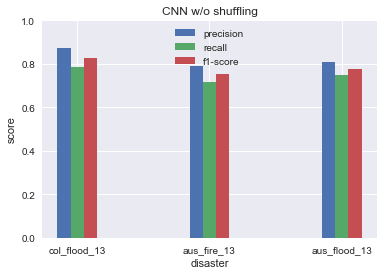

In [43]:
p, r, f = metric_drawing(title='CNN w/o shuffling', path='cnn_unnormalized_unshuffle.h5')

In [44]:
print p, r, f

[0.87138263665594851, 0.79120879120879117, 0.80975609756097566] [0.78437047756874101, 0.71760797342192695, 0.7488721804511278] [0.8255902513328256, 0.7526132404181185, 0.77812499999999996]


In [45]:
######################try hard label incremental learning####################################
cnn_model = load_model('cnn_unnormalized_unshuffle.h5')
print cnn_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))
incremental_learning_det(cnn_model, col_flood_13_g, step=10, confidence=0.85)
print cnn_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))

917/917 [==============================] - 0s 378us/step
[0.58480730032062844, 0.75027262839522202]
917/917 [==============================] - 0s 87us/step
[0.57076112563633474, 0.80588876811082644]


In [46]:
cnn_model = load_model('cnn_unnormalized_unshuffle.h5')
print cnn_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))
incremental_learning_det(cnn_model, aus_fire_13_g, step=10, confidence=0.85)
print cnn_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))

1079/1079 [==============================] - 0s 388us/step
[0.63676479798538799, 0.73679332698905109]
1079/1079 [==============================] - 0s 83us/step
[0.76761305873542063, 0.66357738696611845]


In [47]:
cnn_model = load_model('cnn_unnormalized_unshuffle.h5')
print cnn_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))
incremental_learning_det(cnn_model, aus_flood_13_g, step=10, confidence=0.85)
print cnn_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))

1112/1112 [==============================] - 0s 349us/step
[0.62804132099631882, 0.74460431654676262]
1112/1112 [==============================] - 0s 91us/step
[0.72298197566176492, 0.73291366949355863]


In [48]:
######################try weighted label incremental learning####################################
cnn_model = load_model('cnn_unnormalized_unshuffle.h5')
print cnn_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))
incremental_learning_prob(cnn_model, col_flood_13_g, step=10, threshold=0.75)
print cnn_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))

917/917 [==============================] - 0s 520us/step
[0.58480730032062844, 0.75027262839522202]
917/917 [==============================] - 0s 87us/step
[0.5548122971762488, 0.80370774302903802]


In [49]:
cnn_model = load_model('cnn_unnormalized_unshuffle.h5')
print cnn_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))
incremental_learning_prob(cnn_model, aus_fire_13_g, step=10, threshold=0.75)
print cnn_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))

1079/1079 [==============================] - 1s 487us/step
[0.63676479798538799, 0.73679332698905109]
1079/1079 [==============================] - 0s 79us/step
[0.75722530575346569, 0.66450417102543258]


In [50]:
cnn_model = load_model('cnn_unnormalized_unshuffle.h5')
print cnn_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))
incremental_learning_prob(cnn_model, aus_flood_13_g, step=10, threshold=0.75)
print cnn_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))

1112/1112 [==============================] - 1s 476us/step
[0.62804132099631882, 0.74460431654676262]
1112/1112 [==============================] - 0s 122us/step
[0.70059618332403173, 0.73291366949355863]


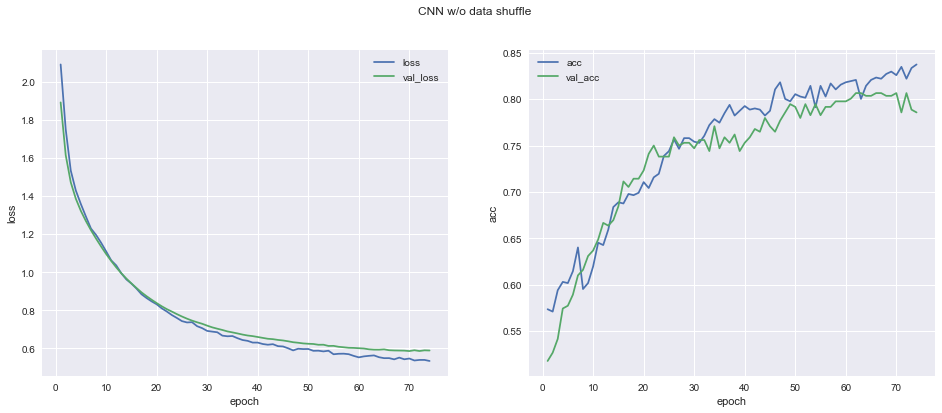

In [51]:
plot_history(history, 'CNN w/o data shuffle', dictionary=False)

In [52]:
cnn_model2 = create_cnn_model([8,4],[3,2],3, 0.2, 0.05, 25)

In [53]:
%%time
history2 = shuffle_train(cnn_model2, col_fire_12, col_fire_12_g, 'cnn_unnormalized_shuffle.h5')

earlystop is not specified or the input is invalid(has either to be an int or a list with length equal to k), use default setting
Train on 893 samples, validate on 224 samples
Epoch 1/10
893/893 [==============================] - 1s 1ms/step - loss: 1.8510 - acc: 0.4216 - val_loss: 1.6542 - val_acc: 0.4821
Epoch 2/10
893/893 [==============================] - 0s 189us/step - loss: 1.6362 - acc: 0.4714 - val_loss: 1.5576 - val_acc: 0.4955
Epoch 3/10
893/893 [==============================] - 0s 203us/step - loss: 1.5230 - acc: 0.5286 - val_loss: 1.4863 - val_acc: 0.5000
Epoch 4/10
893/893 [==============================] - 0s 220us/step - loss: 1.4510 - acc: 0.5442 - val_loss: 1.4149 - val_acc: 0.5223
Epoch 5/10
893/893 [==============================] - 0s 208us/step - loss: 1.3641 - acc: 0.5980 - val_loss: 1.3503 - val_acc: 0.5402
Epoch 6/10
893/893 [==============================] - 0s 220us/step - loss: 1.3034 - acc: 0.5980 - val_loss: 1.2932 - val_acc: 0.5670
Epoch 7/10
893/893 [==

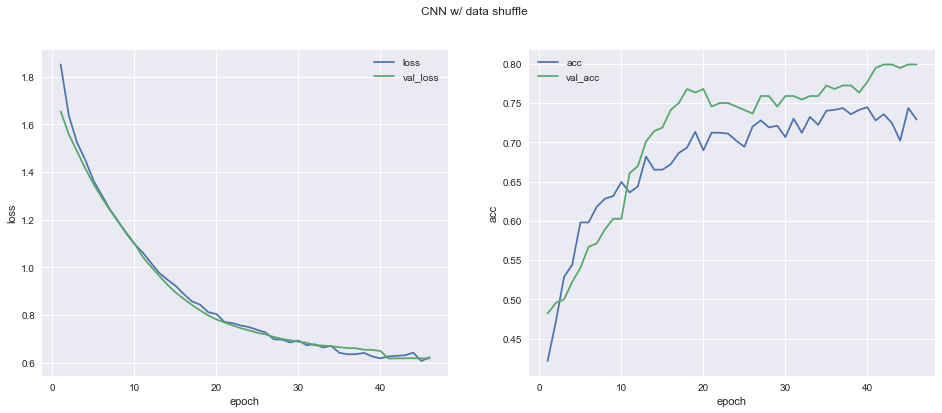

In [55]:
plot_history(history2, 'CNN w/ data shuffle', dictionary=True)

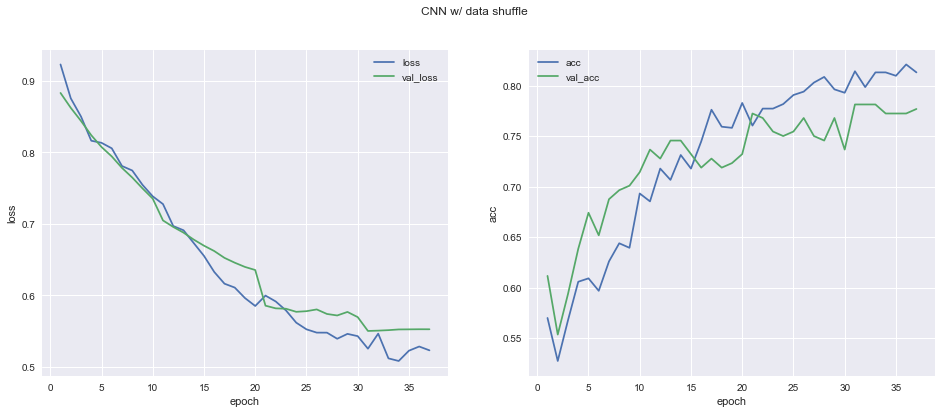

In [69]:
plot_history(history3, 'CNN w/ data shuffle', dictionary=True)

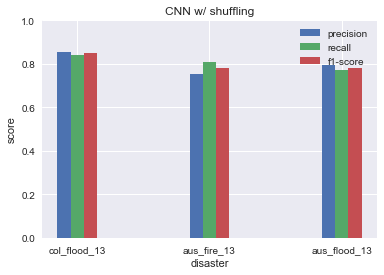

In [56]:
p, r, f = metric_drawing('CNN w/ shuffling', path='cnn_unnormalized_shuffle.h5')

In [57]:
print p, r, f

[0.85588235294117643, 0.75192604006163333, 0.79379844961240309] [0.84225759768451525, 0.81063122923588038, 0.76992481203007523] [0.84901531728665214, 0.78017585931255007, 0.78167938931297709]


In [59]:
######################try hard label incremental learning####################################
cnn_model = load_model('cnn_unnormalized_shuffle.h5')
print cnn_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))
incremental_learning_det(cnn_model, col_flood_13_g, step=10, confidence=0.8)
print cnn_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))

917/917 [==============================] - 1s 606us/step
[0.60683652261351295, 0.77426390448989368]
917/917 [==============================] - 0s 82us/step
[0.59651484568740443, 0.77426390442489412]


In [60]:
cnn_model = load_model('cnn_unnormalized_shuffle.h5')
print cnn_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))
incremental_learning_det(cnn_model, aus_fire_13_g, step=10, confidence=0.8)
print cnn_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))

1079/1079 [==============================] - 1s 526us/step
[0.64429571006561015, 0.74513438396480369]
1079/1079 [==============================] - 0s 73us/step
[0.64273652105667289, 0.74142724750658451]


In [61]:
cnn_model = load_model('cnn_unnormalized_shuffle.h5')
print cnn_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))
incremental_learning_det(cnn_model, aus_flood_13_g, step=10, confidence=0.8)
print cnn_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))

1112/1112 [==============================] - 1s 525us/step
[0.65487365328150693, 0.74280575582449382]
1112/1112 [==============================] - 0s 79us/step
[0.64823311953235874, 0.75]


In [62]:
######################try weighted label incremental learning####################################
cnn_model = load_model('cnn_unnormalized_shuffle.h5')
print cnn_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))
incremental_learning_prob(cnn_model, col_flood_13_g, step=10, threshold=0.8)
print cnn_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))

917/917 [==============================] - 1s 723us/step
[0.60683652261351295, 0.77426390448989368]
917/917 [==============================] - 0s 84us/step
[0.59954493912901718, 0.76881134172042298]


In [63]:
cnn_model = load_model('cnn_unnormalized_shuffle.h5')
print cnn_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))
incremental_learning_prob(cnn_model, aus_fire_13_g, step=10, threshold=0.8)
print cnn_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))

1079/1079 [==============================] - 1s 610us/step
[0.64429571006561015, 0.74513438396480369]
1079/1079 [==============================] - 0s 85us/step
[0.64313549709275875, 0.74698795186246958]


In [64]:
cnn_model = load_model('cnn_unnormalized_shuffle.h5')
print cnn_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))
incremental_learning_prob(cnn_model, aus_flood_13_g, step=10, threshold=0.8)
print cnn_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))

1112/1112 [==============================] - 1s 627us/step
[0.65487365328150693, 0.74280575582449382]
1112/1112 [==============================] - 0s 76us/step
[0.65053610492953295, 0.74730215827338131]


In [67]:
cnn_model3 = create_cnn_model([8,4],[3,2],3, 0.2, 0.01, 25)

In [68]:
%%time
history3 = shuffle_train(cnn_model3, col_fire_12, col_fire_12_g, 'cnn_unnormalized_shuffle2.h5')

earlystop is not specified or the input is invalid(has either to be an int or a list with length equal to k), use default setting
Train on 893 samples, validate on 224 samples
Epoch 1/10
893/893 [==============================] - 2s 2ms/step - loss: 0.9229 - acc: 0.5700 - val_loss: 0.8830 - val_acc: 0.6116
Epoch 2/10
893/893 [==============================] - 0s 176us/step - loss: 0.8755 - acc: 0.5274 - val_loss: 0.8622 - val_acc: 0.5536
Epoch 3/10
893/893 [==============================] - 0s 197us/step - loss: 0.8500 - acc: 0.5677 - val_loss: 0.8439 - val_acc: 0.5938
Epoch 4/10
893/893 [==============================] - 0s 227us/step - loss: 0.8163 - acc: 0.6058 - val_loss: 0.8239 - val_acc: 0.6384
Epoch 5/10
893/893 [==============================] - 0s 215us/step - loss: 0.8133 - acc: 0.6092 - val_loss: 0.8075 - val_acc: 0.6741
Epoch 6/10
893/893 [==============================] - 0s 202us/step - loss: 0.8056 - acc: 0.5969 - val_loss: 0.7943 - val_acc: 0.6518
Epoch 7/10
893/893 [==

In [70]:
increment_learning_result('cnn_unnormalized_shuffle2.h5', step=10, confidence=0.9, threshold=0.75, separate=True)

no incremental learning:
917/917 [==============================] - 1s 752us/step
[0.56134462616565828, 0.7720828791481068]
1079/1079 [==============================] - 0s 98us/step
[0.61544010559644158, 0.74142724728562193]
1112/1112 [==============================] - 0s 81us/step
[0.62710183901752503, 0.72931654633377951]
hard label:
917/917 [==============================] - 1s 755us/step
[0.55332407280558982, 0.77971646699936592]
1079/1079 [==============================] - 1s 750us/step
[0.61517876513695913, 0.74328081540425028]
1112/1112 [==============================] - 1s 722us/step
[0.62061322721645984, 0.74010791409787513]
labels with weight:
917/917 [==============================] - 1s 889us/step
[0.55357995853559272, 0.77971646699936592]
1079/1079 [==============================] - 1s 830us/step
[0.61508684527332635, 0.74328081540425028]
1112/1112 [==============================] - 1s 788us/step
[0.62176259258668198, 0.73920863352233557]


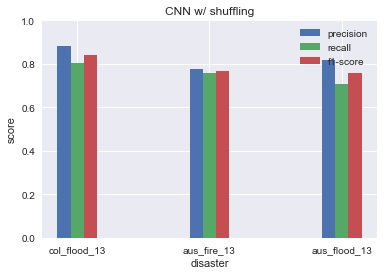

In [71]:
p, r, f = metric_drawing('CNN w/ shuffling', path='cnn_unnormalized_shuffle2.h5')

In [72]:
print p, r, f

[0.88132911392405067, 0.77419354838709675, 0.81707317073170727] [0.80607814761215635, 0.75747508305647837, 0.70526315789473681] [0.84202569916855641, 0.76574307304785894, 0.75706214689265539]


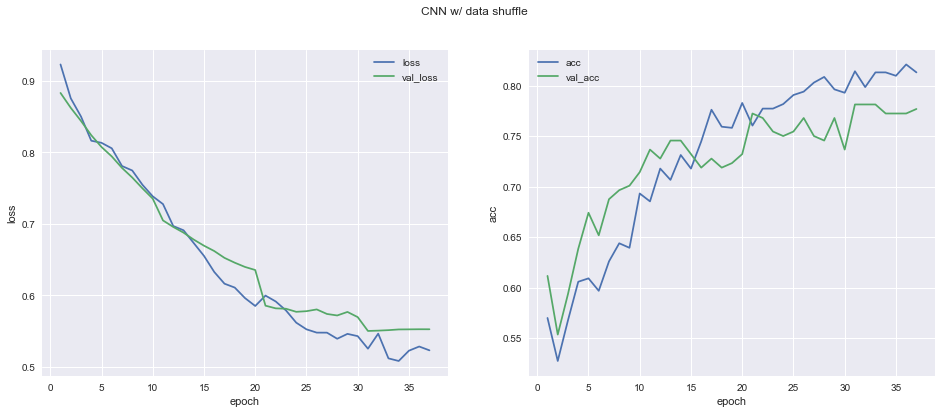

In [73]:
plot_history(history3, 'CNN w/ data shuffle', dictionary=True)

In [76]:
%%time
model = create_cnn_model([8,4],[3,2],3, 0, 0.01, 25, initial_lr=0.01)
history4 = shuffle_train(model, col_fire_12, col_fire_12_g, 'cnn_640_batch_shuffle.h5', val_size=0.2, batch_size=640)

earlystop is not specified or the input is invalid(has either to be an int or a list with length equal to k), use default setting
Train on 893 samples, validate on 224 samples
Epoch 1/10
893/893 [==============================] - 2s 3ms/step - loss: 1.1371 - acc: 0.4535 - val_loss: 0.9390 - val_acc: 0.3973
Epoch 2/10
893/893 [==============================] - 0s 145us/step - loss: 0.8848 - acc: 0.4916 - val_loss: 0.8486 - val_acc: 0.5491
Epoch 3/10
893/893 [==============================] - 0s 176us/step - loss: 0.8469 - acc: 0.5700 - val_loss: 0.8262 - val_acc: 0.5759
Epoch 4/10
893/893 [==============================] - 0s 142us/step - loss: 0.8437 - acc: 0.5588 - val_loss: 0.8164 - val_acc: 0.5982
Epoch 5/10
893/893 [==============================] - 0s 130us/step - loss: 0.8330 - acc: 0.5554 - val_loss: 0.8009 - val_acc: 0.5982
Epoch 6/10
893/893 [==============================] - 0s 138us/step - loss: 0.8154 - acc: 0.5554 - val_loss: 0.7853 - val_acc: 0.5938
Epoch 7/10
893/893 [==

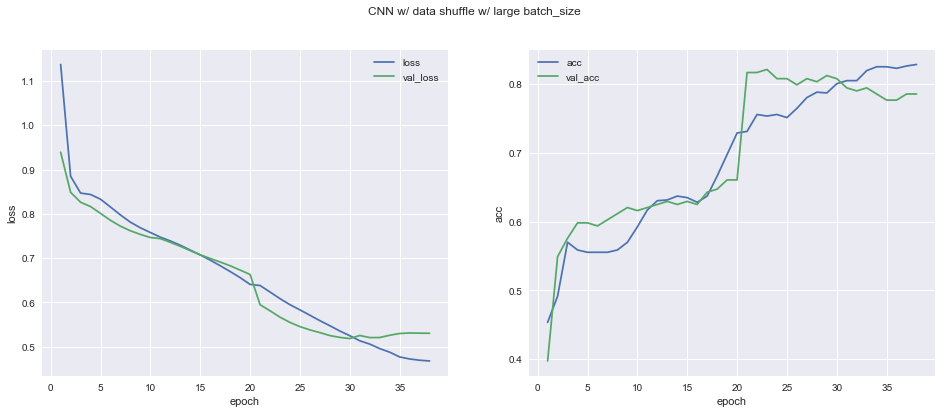

In [77]:
plot_history(history4, 'CNN w/ data shuffle w/ large batch_size', dictionary=True)

In [78]:
increment_learning_result('cnn_640_batch_shuffle.h5', step=10, confidence=0.9, threshold=0.75, separate=True)

no incremental learning:
917/917 [==============================] - 1s 985us/step
[0.58717469177173298, 0.76008724132826955]
1079/1079 [==============================] - 0s 116us/step
[0.62087769702808848, 0.72011121436332093]
1112/1112 [==============================] - 0s 127us/step
[0.62430383447262883, 0.73381294964028776]
hard label:
917/917 [==============================] - 1s 979us/step
[0.55128271993139966, 0.76881134165542331]
1079/1079 [==============================] - 1s 893us/step
[0.63395609775000528, 0.72381835015865248]
1112/1112 [==============================] - 1s 926us/step
[0.60462648705612843, 0.75179856157988956]
labels with weight:
917/917 [==============================] - 1s 1ms/step
[0.55254409695399631, 0.76990185419631763]
1079/1079 [==============================] - 1s 973us/step
[0.62986510257349726, 0.72011121414235835]
1112/1112 [==============================] - 1s 936us/step
[0.61090867853850772, 0.74370503640003338]


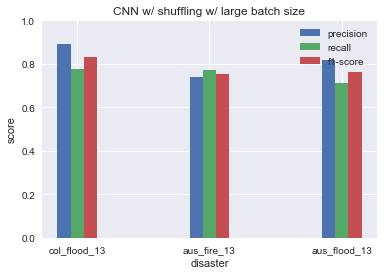

In [79]:
p, r, f = metric_drawing('CNN w/ shuffling w/ large batch size', path='cnn_640_batch_shuffle.h5')

In [80]:
print p, r, f

[0.89184692179700498, 0.73885350318471332, 0.81865284974093266] [0.77568740955137483, 0.77076411960132896, 0.71278195488721807] [0.8297213622291022, 0.75447154471544708, 0.76205787781350487]


In [83]:
#keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB') # or'LR'

# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# SVG(model_to_dot(cnn_model2).create(prog='dot', format='svg'))
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='LR')